In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Data Sourcing
Both datasets were found on data.gov Initial steps are to read in data and investigate any immediate errors.

#### Links
Crashes:
https://catalog.data.gov/dataset/allegheny-county-crash-data

Traffic:
https://catalog.data.gov/dataset/allegheny-county-traffic-counts

In [2]:
crash = pd.read_csv('crashdata.csv')
crash.head()

C:\Users\Ari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (79,183) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CRASH_CRN,DISTRICT,CRASH_COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,ACCESS_CTRL,ROADWAY_COUNTY,LANE_COUNT,RDWY_ORIENT,ROAD_OWNER,ROUTE,SPEED_LIMIT,SEGMENT,OFFSET,STREET_NAME
0,2.004000e+09,11.0,2.0,2454.0,02454,2004.0,1.0,5.0,257.0,2.0,...,3.0,2.0,2.0,E,2.0,2032,35.0,10.0,1000.0,LEWIS RUN RD
1,2.004000e+09,11.0,2.0,2440.0,02440,2004.0,1.0,5.0,1027.0,10.0,...,NaN,2.0,2.0,W,3.0,NaN,35.0,NaN,NaN,COAL VALLEY RD
2,2.004000e+09,11.0,2.0,2203.0,02203,2004.0,1.0,5.0,1839.0,18.0,...,NaN,2.0,2.0,W,2.0,3082,35.0,NaN,NaN,CLINTON FRANKFORT RD
3,2.004000e+09,11.0,2.0,2404.0,02404,2004.0,1.0,6.0,914.0,9.0,...,NaN,2.0,2.0,N,4.0,NaN,25.0,NaN,NaN,NORTH BALPH AV
4,2.004000e+09,11.0,2.0,2419.0,02419,2004.0,1.0,5.0,2230.0,22.0,...,NaN,2.0,2.0,S,4.0,NaN,20.0,NaN,NaN,THORNBERRY DR


In [3]:
# Investigate mixed type columns
# WZ_FLAGGER records if workzone had flagman, ROUTE records route number
# Neither needed columns
odd_typed = crash.iloc[:,[79,183]]
odd_typed.applymap(type).head()

,WZ_FLAGGER,ROUTE
0,<class 'float'>,<class 'str'>
1,<class 'float'>,<class 'float'>
2,<class 'float'>,<class 'str'>
3,<class 'float'>,<class 'float'>
4,<class 'float'>,<class 'float'>


In [121]:
traffic = pd.read_csv('data-trafficcounts.csv')
traffic.head()

,sensor_ID,Longitude,Latitude,1a,2a,3a,4a,5a,6a,7a,...,3p,4p,5p,6p,7p,8p,9p,10p,11p,12a
0,5879@1,-79.861523,40.625398,44.0,19.0,14.0,18.0,36.0,151.0,362.0,...,481.0,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0
1,5970@1,-79.796409,40.445047,18.0,19.0,24.0,31.0,100.0,223.0,356.0,...,463.0,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0
2,5957@1,-79.820976,40.487624,60.0,36.0,39.0,27.0,45.0,165.0,395.0,...,532.0,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0
3,120@1,-79.703859,40.443548,27.0,7.0,14.0,9.0,35.0,119.0,365.0,...,508.0,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0
4,26732@1,-80.114273,40.389899,19.0,14.0,7.0,10.0,9.0,33.0,113.0,...,195.0,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0


## Data Cleaning Steps
#### 1) Slice crash df to useful columns
These columns will fall into following categories: severity (fatalities, injuries, etc.), date-time, location (latittude, longitude), conditions (weather, speed limit, brightness)

#### 2) Verify relationship between crashes and traffic
Scatter plots of aggregated traffic and crash data can confirm a positive correlation. Furthermore, after regularization there should be no correlation between aggregate regularized crash count and aggregate traffic.

#### 3) Regularize crash df using traffic
Each crash will be divided by the traffic at the closest sensor at the appropriate hour therfore weighting accidents that happened at high traffic times lower than those at low traffic times. This is advantageous because our goal is to find safe routes which means accident rate (crashes/traffic) is required data.

## 1) Crash df munge

In [5]:
# Creating dataframe of just time attributes
crash_time = crash[['CRASH_YEAR', 'CRASH_MONTH', 'HOUR_OF_DAY', 'TIME_OF_DAY', 'DAY_OF_WEEK']]
# Limitation of data is day of week is recorded but not day
crash_time.DAY_OF_WEEK.max()
crash_time.columns = ['year', 'month', 'hour', 'time', 'day']

In [6]:
# Replacing NaN
crash_time.replace(9999,np.NaN, inplace = True)

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [7]:
# Converting to int for datetime
crash_time.dropna().astype(int).head()

,year,month,hour,time,day
0,2004,1,2,257,5
1,2004,1,10,1027,5
2,2004,1,18,1839,5
3,2004,1,9,914,6
4,2004,1,22,2230,5


In [8]:
# Creating minute column from last 2 digits of time
crash_time['minute'] = crash_time.time % 100
crash_time.head()

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,year,month,hour,time,day,minute
0,2004.0,1.0,2.0,257.0,5.0,57.0
1,2004.0,1.0,10.0,1027.0,5.0,27.0
2,2004.0,1.0,18.0,1839.0,5.0,39.0
3,2004.0,1.0,9.0,914.0,6.0,14.0
4,2004.0,1.0,22.0,2230.0,5.0,30.0


In [9]:
# Note that the day will only be between 1 and 7 because no exact day information is available
crash_datetime = pd.to_datetime(crash_time[['year', 'month', 'day', 'hour', 'minute']])

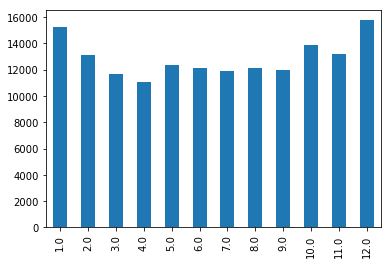

In [10]:
# Can access datetime information using dt to easily visualize crash frequency with any time component
crash_datetime.dt.month.value_counts().sort_index().plot(kind = 'bar')

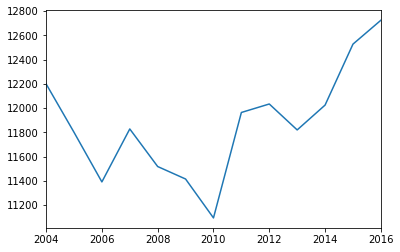

In [11]:
crash_datetime.dt.year.value_counts().sort_index().plot()

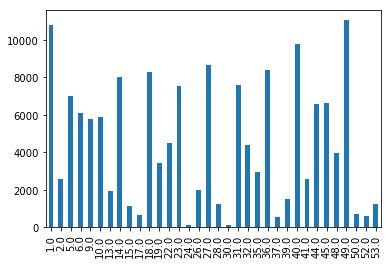

In [12]:
# Weekly graph looks odd because using day of week as day in datetime format eliminates all week 3/4 data for any month
crash_datetime.dt.week.value_counts().sort_index().plot(kind = 'bar')

In [13]:
# Dataframe of crash locations and street names
crash_location = crash[['DEC_LAT', 'DEC_LONG', 'STREET_NAME']]
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME
0,40.3234,-79.9404,LEWIS RUN RD
1,40.3182,-79.9076,COAL VALLEY RD
2,40.4886,-80.3371,CLINTON FRANKFORT RD
3,NaN,NaN,NORTH BALPH AV
4,NaN,NaN,THORNBERRY DR


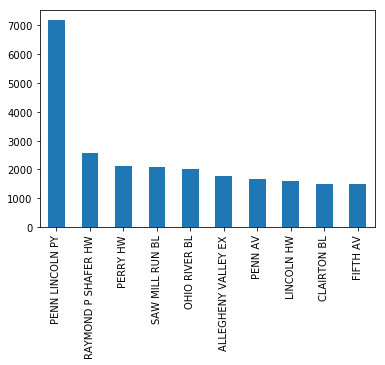

In [14]:
# 10 most dangerous roads (Most are highways)
crash_location.STREET_NAME.value_counts().head(10).plot(kind = 'bar')

In [15]:
crash_severity = crash[['FATAL', 'FATAL_COUNT', 'FATAL_OR_MAJ_INJ', 'INJURY', 'INJURY_COUNT', 'MAJ_INJ_COUNT', 'MAJOR_INJURY', 'MAX_SEVERITY_LEVEL', 'VEHICLE_COUNT']]
crash_severity.describe()

,FATAL,FATAL_COUNT,FATAL_OR_MAJ_INJ,INJURY,INJURY_COUNT,MAJ_INJ_COUNT,MAJOR_INJURY,MAX_SEVERITY_LEVEL,VEHICLE_COUNT
count,157821.000000,157821.000000,157821.00000,157821.000000,157821.000000,157821.000000,157821.000000,157821.000000,157821.000000
mean,0.005437,0.005823,0.02411,0.459894,0.629650,0.021398,0.019389,2.614829,1.829319
std,0.073532,0.081553,0.15339,0.498391,0.863664,0.160406,0.137889,3.086497,0.764823
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,4.000000,2.000000
max,1.000000,3.000000,1.00000,1.000000,44.000000,5.000000,1.000000,9.000000,14.000000


In [16]:
crash_severity.MAX_SEVERITY_LEVEL.head()

0    0.0
1    3.0
2    4.0
3    3.0
4    0.0
Name: MAX_SEVERITY_LEVEL, dtype: float64

In [17]:
# Definitions from Data Dictionary
severity_di = {0:'Not injured',
              1: 'Killed',
            2: 'Major Injury',
               3: 'Moderate Injury',
               4: 'Minor Injury',
               8: 'Injury/Unknown Severity',
               9: np.NaN}
crash_severity.MAX_SEVERITY_LEVEL = crash_severity.MAX_SEVERITY_LEVEL.map(severity_di)

C:\Users\Ari\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


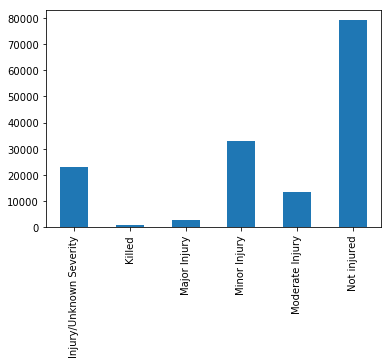

In [18]:
crash_severity.MAX_SEVERITY_LEVEL.value_counts().sort_index().plot(kind = 'bar')

In [19]:
crash_conditions = crash[['WEATHER', 'ILLUMINATION', 'INTERSECT_TYPE', 'LOCATION_TYPE', 'RELATION_TO_ROAD', 'ROAD_CONDITION', 'SPEED_LIMIT', 'TCD_FUNC_CD', 'TCD_TYPE']]
crash_conditions.head()

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_FUNC_CD,TCD_TYPE
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0,0.0
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0,0.0
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0
3,1.0,1.0,1.0,0.0,1.0,1.0,25.0,3.0,2.0
4,1.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0


In [20]:
weather_di = {1:'No adverse conditions',
              2: 'Rain',
              3: 'Sleet (hail)',
              4: 'Snow',
              5: 'Fog',
              6: 'Rain and fog',
              7: 'Sleet and fog',
              8: 'Other',
              9: np.NaN}
illumination_di = {1: 'Daylight',
                   2: 'Dark - no street lights',
                   3: 'Dark - street lights',
                   4: 'Dusk',
                   5: 'Dawn',
                   6: 'Dark - unknown roadway lighting',
                   8: 'Other',
                   9: np.NaN}
intersect_di = {0: 'Mid-block',
                1: 'Four way intersection',
                2: 'T intersection',
                3: 'Y intersection',
                4: 'Traffic circle/Round about',
                5: 'Multi-leg intersection',
                6: 'On ramp',
                7: 'Off ramp',
                8: 'Crossover',
                9: 'Railroad crossing',
                10: 'Other',
                99: np.NaN}
location_di = {0: 'Not applicable',
               1: 'Underpass',
               2: 'Ramp',
               3: 'Bridge',
               4: 'Tunnel',
               5: 'Toll Booth',
               6: 'Cross over related',
               7: 'Driveway or Parking Lot',
               8: 'Ramp and bridge',
               9: np.NaN}
relation_di = {1: 'On roadway',
               2: 'Shoulder',
               3: 'Median',
               4: 'Roadside',
               5: 'Outside trafficway',
               6: 'In parking lane',
               7: 'Gore',
               9: np.NaN}
# Gore is intersection of ramp and highway
road_cond = {0: 'Dry',
             1: 'Wet',
             2: 'Sand/mud/dirt/oil/gravel',
             3: 'Snow covered',
             4: 'Slush',
             5: 'Ice', 
             6: 'Ice Patches',
             7: 'Water - standing/moving',
             8: 'Other',
             9: np.NaN}
tcdtype_di = {0: np.NaN,
              1: 'Flashing traffic signal',
              2: 'Traffic signal',
              3: 'Stop sign',
              4: 'Yield sign',
              5: 'Active RR crossing controls',
              6: 'Passive RR crossing controls',
              7: 'Police officer or flagman',
              8: 'Other type TCD'}

In [21]:
# Add additional columns with descriptive information from dictionaries above
crash_conditions['WEATHER_DES'] = crash_conditions.WEATHER.map(weather_di)
crash_conditions['ILLUMINATION_DES'] = crash_conditions.ILLUMINATION.map(illumination_di)
crash_conditions['INTERSECT_DES'] = crash_conditions.INTERSECT_TYPE.map(intersect_di)
crash_conditions['LOCATION_DES'] = crash_conditions.LOCATION_TYPE.map(location_di)
crash_conditions['ROAD_RELATION_DES'] = crash_conditions.RELATION_TO_ROAD.map(relation_di)
crash_conditions['ROAD_CONDITION_DES'] = crash_conditions.ROAD_CONDITION.map(road_cond)
crash_conditions['TCD_DES'] = crash_conditions.TCD_TYPE.map(tcdtype_di)
crash_conditions.head()

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_FUNC_CD,TCD_TYPE,WEATHER_DES,ILLUMINATION_DES,INTERSECT_DES,LOCATION_DES,ROAD_RELATION_DES,ROAD_CONDITION_DES,TCD_DES
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0,0.0,No adverse conditions,Dark - no street lights,Mid-block,Not applicable,Shoulder,Dry,NaN
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0,0.0,No adverse conditions,Daylight,Mid-block,Not applicable,Outside trafficway,Ice Patches,NaN
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign
3,1.0,1.0,1.0,0.0,1.0,1.0,25.0,3.0,2.0,No adverse conditions,Daylight,Four way intersection,Not applicable,On roadway,Wet,Traffic signal
4,1.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,No adverse conditions,Dark - street lights,Mid-block,Not applicable,On roadway,Dry,NaN


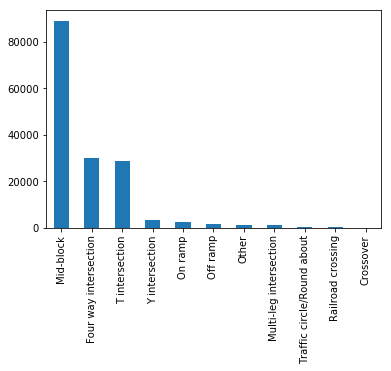

In [22]:
# Most common crash intersection types
crash_conditions.INTERSECT_DES.value_counts().plot(kind = 'bar')

## 2) Visualizing aggregate crashes vs aggregate traffic

In [23]:
# Traffic by hour
t_hour = traffic.iloc[:,3:]

,1a,2a,3a,4a,5a,6a,7a,8a,9a,10a,...,3p,4p,5p,6p,7p,8p,9p,10p,11p,12a
0,44.0,19.0,14.0,18.0,36.0,151.0,362.0,606.0,477.0,315.0,...,481.0,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0
1,18.0,19.0,24.0,31.0,100.0,223.0,356.0,385.0,296.0,297.0,...,463.0,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0
2,60.0,36.0,39.0,27.0,45.0,165.0,395.0,584.0,478.0,423.0,...,532.0,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0
3,27.0,7.0,14.0,9.0,35.0,119.0,365.0,550.0,539.0,421.0,...,508.0,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0
4,19.0,14.0,7.0,10.0,9.0,33.0,113.0,232.0,220.0,173.0,...,195.0,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0


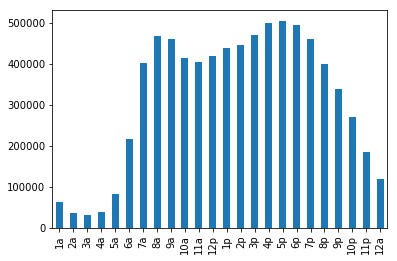

In [24]:
# Dropping NaN and visualizng total average traffic at all sensors each hour
t_hour.replace(-1,np.nan, inplace=True)
t_hour.dropna().sum().plot(kind = 'bar')
t_hour.head()

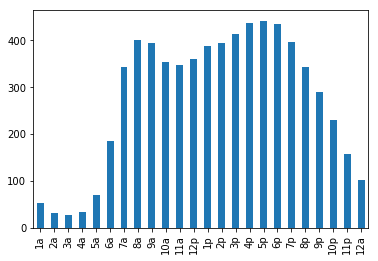

In [25]:
# Visualizng average traffic at a sensor each hour
t_hour.mean().plot(kind = 'bar')

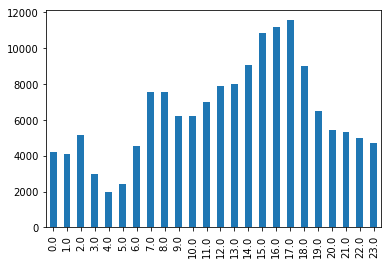

In [26]:
# Visualizing total crashes each hour
crash['HOUR_OF_DAY'].replace(99, np.nan, inplace = True)
c_hour = crash['HOUR_OF_DAY'].value_counts().sort_index()
c_hour.plot(kind = 'bar')

In [27]:
# Building series of average traffic with 0-23 hour labels
avg_t = t_hour.mean()
c_hour = c_hour.astype(float)
avg_t.reset_index(drop = True, inplace = True)
avg_t.index = (avg_t.index + 1) % 24

In [28]:
# Building series of total traffic with 0-23 hour labels
sum_t = t_hour.sum()
sum_t.reset_index(drop = True, inplace = True)
sum_t.index = (avg_t.index + 1) % 24

In [29]:
# Building dataframe of total crashes, and average traffic each hour
c_sum_t_avg = pd.concat([c_hour, avg_t], axis = 1)
c_sum_t_avg.columns = ['Total Crashes', 'Average traffic']
c_sum_t_avg.head()

,Total Crashes,Average traffic
0.0,4179.0,101.616356
1.0,4082.0,53.796416
2.0,5157.0,31.218393
3.0,2961.0,27.397583
4.0,1968.0,34.771707


In [30]:
# Building dataframe of total crashes, and total average traffic each hour
ct_sum = pd.concat([c_hour, sum_t], axis = 1)
ct_sum.columns = ['Total Crashes', 'City-wide Average traffic']
ct_sum.head()

,Total Crashes,City-wide Average traffic
0.0,4179.0,186200.833333
1.0,4082.0,120008.916667
2.0,5157.0,62296.250000
3.0,2961.0,35557.750000
4.0,1968.0,30986.666667


Positive correlations are found as expected in scatter plots of aggregate traffic/crash data. The exact correlation is unimportant but the visualization supports the need for regularization.

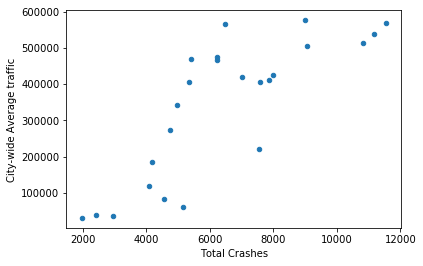

In [31]:
ct_sum.plot.scatter(x = 'Total Crashes', y = 'City-wide Average traffic')

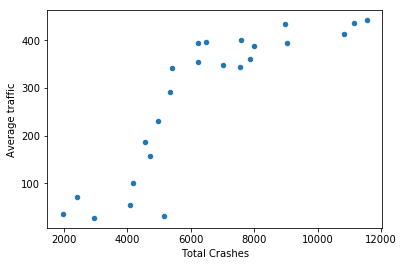

In [32]:
c_sum_t_avg.plot.scatter(x = 'Total Crashes', y = 'Average traffic')

## 3) Regularize crash df using traffic sensors

Traffic data was taken between the years 2012-2014 and consists of hourly averages over this time period at each of the sensor locations specified by coordinate value in the traffic df. Crash data is taken between 2004 and 2016. These limitations will introduce error in regularization if traffic patterns changed significantly outside of the years for which data is recorded but regularized result should still be improvement (this can be tested by observing correlation between aggregated traffic and crashes which should be 0 for regularized and strongly positive for non-regularized.

Also note that because traffic data is taken as averages, regularization will not be sufficient to answer questions like - How much more dangerous is it to drive in the rain vs on a clear day? In order to answer that, or similar questions traffic data would need to be recorded on daily basis to associate with weather or other time-dependant conditions.

In [33]:
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME
0,40.3234,-79.9404,LEWIS RUN RD
1,40.3182,-79.9076,COAL VALLEY RD
2,40.4886,-80.3371,CLINTON FRANKFORT RD
3,NaN,NaN,NORTH BALPH AV
4,NaN,NaN,THORNBERRY DR


In [122]:
# Replacing null values
traffic.replace(-1,np.NaN,inplace = True)
traffic.head(10)

,sensor_ID,Longitude,Latitude,1a,2a,3a,4a,5a,6a,7a,...,3p,4p,5p,6p,7p,8p,9p,10p,11p,12a
0,5879@1,-79.861523,40.625398,44.0,19.0,14.0,18.0,36.0,151.0,362.0,...,481.0,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0
1,5970@1,-79.796409,40.445047,18.0,19.0,24.0,31.0,100.0,223.0,356.0,...,463.0,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0
2,5957@1,-79.820976,40.487624,60.0,36.0,39.0,27.0,45.0,165.0,395.0,...,532.0,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0
3,120@1,-79.703859,40.443548,27.0,7.0,14.0,9.0,35.0,119.0,365.0,...,508.0,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0
4,26732@1,-80.114273,40.389899,19.0,14.0,7.0,10.0,9.0,33.0,113.0,...,195.0,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0
5,27598@1,-80.034512,40.438256,45.0,40.0,28.0,42.0,58.0,270.0,734.0,...,767.0,815.0,84.0,988.0,697.0,523.0,321.0,312.0,193.0,122.0
6,3688@1,-80.279735,40.510567,52.0,42.0,15.0,21.0,30.0,76.0,248.0,...,612.0,682.0,717.0,628.0,406.0,369.0,326.0,281.0,174.0,127.0
7,6029@1,-79.819557,40.369132,5.0,1.0,NaN,7.0,15.0,31.0,39.0,...,76.0,99.0,78.0,72.0,56.0,56.0,35.0,30.0,9.0,6.0
8,27849@1,-79.998630,40.451181,12.0,14.0,26.0,19.0,18.0,46.0,138.0,...,110.0,127.0,117.0,138.0,116.0,98.0,74.0,57.0,47.0,24.0
9,5510@1,-80.162117,40.384598,1.0,NaN,NaN,NaN,NaN,1.0,1.0,...,4.0,3.0,5.0,14.0,9.0,13.0,11.0,2.0,1.0,1.0


In [35]:
crash_location.dropna(inplace = True)

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
# To find the appropriate sensor to regularize by we find the minimum euclidean distance and return the row of the traffic df
# corresponding with the appropriate sensor

min((abs((crash_location.DEC_LAT[0]-traffic.Latitude)**2-(crash_location.DEC_LONG[0]-traffic.Longitude)**2))**(.5))
testing = (abs((crash_location.DEC_LAT[0]-traffic.Latitude)**2-(crash_location.DEC_LONG[0]-traffic.Longitude)**2))**(.5)
traffic.iloc[testing.argmin(),:]

sensor_ID     6070@1
Longitude   -79.9446
Latitude     40.3277
1a                91
2a                40
3a                60
4a                65
5a               184
6a               611
7a               174
8a               583
9a               260
10a              275
11a              309
12p              441
1p               611
2p               432
3p               507
4p               516
5p               591
6p               719
7p                29
8p               645
9p               506
10p              355
11p              201
12a              163
Name: 428, dtype: object

In [37]:
# Function for finding closest euclidi
def closest_distance(x):
    return min((abs((x.DEC_LAT-traffic.Latitude)**2-(x.DEC_LONG-traffic.Longitude)**2))**(.5))

In [38]:
def closest_sensor(x):
    return traffic.iloc[((abs((x.DEC_LAT-traffic.Latitude)**2-(x.DEC_LONG-traffic.Longitude)**2))**(.5)).argmin(),[1,2]]

In [152]:
# Converting to Cartesian 3D coordinate system allowing usage of euclidean distance
def LLHtoECEF(df):
    # see http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    df.iloc[0] = np.deg2rad(df.iloc[0])         # Convert to radians
    df.iloc[1] = np.deg2rad(df.iloc[1])
    
    rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    f = np.float64(1.0/298.257223563)  # Flattening factor WGS84 Model
    
    cosLat = np.cos(df.iloc[0]) # Latitude is stored in first column
    sinLat = np.sin(df.iloc[0])
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(cosLat**2 + FF * sinLat**2)
    S      = C * FF

    x = (rad * C)*cosLat * np.cos(df.iloc[1]) # Longitude stored in second column
    y = (rad * C)*cosLat * np.sin(df.iloc[1]) 
    z = (rad * S)*sinLat

    return (x, y, z) # Returns tuple of ECEF in meters

In [132]:
LLHtoECEF(crash_location.head(1))
# Sanity check compare to calculator here: http://www.oc.nps.edu/oc2902w/coord/llhxyz.htm

   DEC_LAT  DEC_LONG   STREET_NAME  euc_distance  sensor_long  sensor_lat
0  40.3234  -79.9404  LEWIS RUN RD      0.000368   -79.944645   40.327661
<class 'pandas.core.frame.DataFrame'>


C:\Users\Ari\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0    850576.077991
 dtype: float64, 0   -4.794686e+06
 dtype: float64, 0    4.105429e+06
 Name: DEC_LAT, dtype: float64)

In [52]:
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME,euc_distance,sensor_long,sensor_lat
0,40.3234,-79.9404,LEWIS RUN RD,0.000368,-79.944645,40.327661
1,40.3182,-79.9076,COAL VALLEY RD,0.003447,-79.881813,40.292184
2,40.4886,-80.3371,CLINTON FRANKFORT RD,0.005555,-80.248649,40.399974
3,40.4188,-80.0494,POPLAR ST,0.001987,-80.044417,40.423370
4,40.4612,-80.0087,PERRYSVILLE AV,0.001015,-79.998630,40.451181


In [123]:
# Reordering the traffic dataframe to match the latitude longitude form of the crash dataframe
traffic_cols = traffic.columns.tolist()
traffic_cols = traffic_cols[1:] + [traffic_cols[0]]
traffic_cols[0] = 'Latitude'
traffic_cols[1] = 'Longitude'
traffic = traffic[traffic_cols]
traffic.head()

,Latitude,Longitude,1a,2a,3a,4a,5a,6a,7a,8a,...,4p,5p,6p,7p,8p,9p,10p,11p,12a,sensor_ID
0,40.625398,-79.861523,44.0,19.0,14.0,18.0,36.0,151.0,362.0,606.0,...,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0,5879@1
1,40.445047,-79.796409,18.0,19.0,24.0,31.0,100.0,223.0,356.0,385.0,...,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0,5970@1
2,40.487624,-79.820976,60.0,36.0,39.0,27.0,45.0,165.0,395.0,584.0,...,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0,5957@1
3,40.443548,-79.703859,27.0,7.0,14.0,9.0,35.0,119.0,365.0,550.0,...,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0,120@1
4,40.389899,-80.114273,19.0,14.0,7.0,10.0,9.0,33.0,113.0,232.0,...,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0,26732@1


In [124]:
LLHtoECEF(traffic.head(1))

C:\Users\Ari\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0    853344.192815
 dtype: float64, 0   -4.772083e+06
 dtype: float64, 0    4.130939e+06
 Name: Latitude, dtype: float64)

In [120]:
traffic.head()

,Latitude,Longitude,1a,2a,3a,4a,5a,6a,7a,8a,...,4p,5p,6p,7p,8p,9p,10p,11p,12a,sensor_ID
0,0.012375,-0.024327,44.0,19.0,14.0,18.0,36.0,151.0,362.0,606.0,...,604.0,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0,5879@1
1,40.445047,-79.796409,18.0,19.0,24.0,31.0,100.0,223.0,356.0,385.0,...,561.0,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0,5970@1
2,40.487624,-79.820976,60.0,36.0,39.0,27.0,45.0,165.0,395.0,584.0,...,637.0,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0,5957@1
3,40.443548,-79.703859,27.0,7.0,14.0,9.0,35.0,119.0,365.0,550.0,...,640.0,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0,120@1
4,40.389899,-80.114273,19.0,14.0,7.0,10.0,9.0,33.0,113.0,232.0,...,247.0,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0,26732@1


In [125]:
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME,euc_distance,sensor_long,sensor_lat
0,40.3234,-79.9404,LEWIS RUN RD,0.000368,-79.944645,40.327661
1,40.3182,-79.9076,COAL VALLEY RD,0.003447,-79.881813,40.292184
2,40.4886,-80.3371,CLINTON FRANKFORT RD,0.005555,-80.248649,40.399974
3,40.4188,-80.0494,POPLAR ST,0.001987,-80.044417,40.423370
4,40.4612,-80.0087,PERRYSVILLE AV,0.001015,-79.998630,40.451181


In [126]:
crash_location.reset_index(drop = True, inplace = True);
crash_location.head()

,DEC_LAT,DEC_LONG,STREET_NAME,euc_distance,sensor_long,sensor_lat
0,40.3234,-79.9404,LEWIS RUN RD,0.000368,-79.944645,40.327661
1,40.3182,-79.9076,COAL VALLEY RD,0.003447,-79.881813,40.292184
2,40.4886,-80.3371,CLINTON FRANKFORT RD,0.005555,-80.248649,40.399974
3,40.4188,-80.0494,POPLAR ST,0.001987,-80.044417,40.423370
4,40.4612,-80.0087,PERRYSVILLE AV,0.001015,-79.998630,40.451181


In [41]:
crash_location['euc_distance'] = crash_location.apply(closest_distance, axis = 1)

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [42]:
crash_location[['sensor_long', 'sensor_lat']] = crash_location.apply(closest_sensor, axis = 1)

C:\Users\Ari\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [146]:
type(c.iloc[0:2])

pandas.core.series.Series

In [147]:
c = crash_location.iloc[0,:]
np.deg2rad(c.iloc[0:2])

AttributeError: 'numpy.float64' object has no attribute 'deg2rad'

In [167]:
crash_location['ecef'] = crash_location.apply(LLHtoECEF, axis = 1)
crash_location.head()

C:\Users\Ari\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,DEC_LAT,DEC_LONG,STREET_NAME,euc_distance,sensor_long,sensor_lat,ecef
0,40.3234,-79.9404,LEWIS RUN RD,0.000368,-79.944645,40.327661,"(850576.077991, -4794686.27611, 4105428.63702)"
1,40.3182,-79.9076,COAL VALLEY RD,0.003447,-79.881813,40.292184,"(853386.215354, -4794566.40574, 4104988.39864)"
2,40.4886,-80.3371,CLINTON FRANKFORT RD,0.005555,-80.248649,40.399974,"(815363.016972, -4788738.45089, 4119397.20706)"
3,40.4188,-80.0494,POPLAR ST,0.001987,-80.044417,40.423370,"(840267.393275, -4789537.24936, 4113499.3667)"
4,40.4612,-80.0087,PERRYSVILLE AV,0.001015,-79.998630,40.451181,"(843139.559476, -4785931.47629, 4117082.73095)"


In [169]:
traffic['ecef'] = traffic.apply(LLHtoECEF, axis = 1)
traffic.head()

,Latitude,Longitude,1a,2a,3a,4a,5a,6a,7a,8a,...,5p,6p,7p,8p,9p,10p,11p,12a,sensor_ID,ecef
0,0.709047,-1.393847,44.0,19.0,14.0,18.0,36.0,151.0,362.0,606.0,...,678.0,790.0,575.0,431.0,416.0,227.0,188.0,119.0,5879@1,"(6375764.78704, -155135.180677, 78400.3930585)"
1,40.445047,-79.796409,18.0,19.0,24.0,31.0,100.0,223.0,356.0,385.0,...,535.0,402.0,315.0,258.0,200.0,119.0,78.0,36.0,5970@1,"(861072.600669, -4783920.01924, 4115717.86947)"
2,40.487624,-79.820976,60.0,36.0,39.0,27.0,45.0,165.0,395.0,584.0,...,662.0,715.0,611.0,511.0,429.0,247.0,170.0,106.0,5957@1,"(858479.025047, -4781268.65044, 4119314.81929)"
3,40.443548,-79.703859,27.0,7.0,14.0,9.0,35.0,119.0,365.0,550.0,...,698.0,731.0,471.0,390.0,278.0,146.0,111.0,56.0,120@1,"(868818.27623, -4782629.10297, 4115591.21484)"
4,40.389899,-80.114273,19.0,14.0,7.0,10.0,9.0,33.0,113.0,232.0,...,309.0,348.0,324.0,264.0,181.0,140.0,87.0,54.0,26732@1,"(835201.086995, -4792534.86261, 4111055.53236)"


In [170]:
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,euc_distance,sensor_long,sensor_lat,ecef
142091,40.4541,-79.8908,KELLY ST,0.000499,-79.895663,40.458988,"(853075.781582, -4784690.02494, 4116482.84218)"
142092,40.4578,-79.7397,OLD FRANKSTOWN RD,0.004815,-79.733963,40.454681,"(865643.46358, -4782161.33507, 4116795.46809)"
142093,40.6674,-79.9790,VALENCIA RD,0.000115,-79.978882,40.667375,"(843029.244793, -4770830.63491, 4134477.47916)"
142094,40.4430,-79.8390,PENN LINCOLN PY,0.000851,-79.840078,40.443661,"(857542.248496, -4784703.93343, 4115544.86237)"
142095,40.4435,-80.0068,TENTH ST BY,0.000317,-80.006479,40.443553,"(843519.558023, -4787159.39219, 4115587.117)"


In [172]:
crash_location.ecef[0][0]

850576.07799136976